## 데이터셋 구경

In [1]:
import pandas as pd

df=pd.read_csv('data/metadata_with_Nan.csv')

filter = df[df['Shape_Feature'].isin(['C '])]

filter

,Name,Upper,Category,Shape_Feature,Description
12,BL-001,T,BL,C,스카이 블루 페일 톤 단색
29,BL-002,T,BL,C,아이보리 단색
51,BL-003,T,BL,C,화이트 단색
74,BL-004,T,BL,C,화이트 단색
92,BL-005,T,BL,C,화이트 단색
...,...,...,...,...,...
116967,VT-272,O,VT,C,아이보리 단색
116968,VT-272,O,VT,C,상의 가슴 부분 왼쪽 브라운 대비 색 포인트 배색
116969,VT-272,O,VT,C,상의 암홀 부분 브라운 대비 색 포인트 배색
116970,VT-272,O,VT,C,상의 앞 중심선 부분 오른쪽 브라운 대비 색 포인트 배색


## Feature Extraction - Clustering

In [2]:
import pandas as pd
from torch.utils.data import DataLoader

df=pd.read_csv('data/metadata_with_Nan.csv')
names = set(list(df['Name']))
names = pd.DataFrame(names, columns=['Name'])

In [3]:
from tools.Fashiondataset import FashionDataset

image_folder = 'data/img_jpg'
Dataset=FashionDataset(dataframe=names, image_folder=image_folder)
Dataloader=DataLoader(Dataset, batch_size=16, shuffle=False)

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from tools.ExtractFeature import extract_features_from_images, get_features
from tools.clustering import perform_clustering_with_cache

사용하는 장치: cuda


In [17]:
user_name='default'
model = 'dino' # ['resnet', 'vit', 'dino', 'deit']
force_ex = False
#for i in ['resnet', 'vit', 'dino', 'deit']:
    #features = get_features(user_name, i, Dataloader, force_extract=force_ex)
features = get_features(user_name, model, Dataloader, force_extract=force_ex)

Using cache found in C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
특징 추출: 100%|██████████| 450/450 [02:42<00:00,  2.77it/s]

dino extracted feature saved to saved/default_features_dino.npy.


In [18]:
labels = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=13, force_cluster=force_ex)[0]

저장된 모델을 찾을 수 없습니다: saved/default_dino_13clusters_model.pkl
K-means 클러스터링 수행 중...
default clustered labels were saved to saved/default_labels_dino_13clusters.npy.
모델이 저장되었습니다: saved/default_dino_13clusters_model.pkl


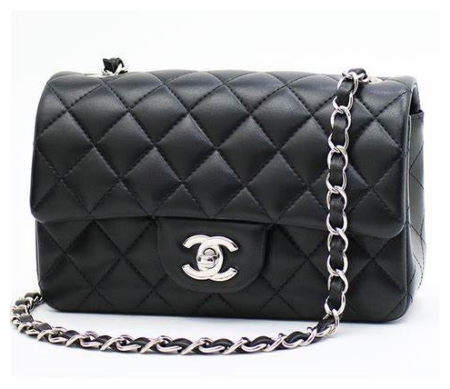

In [19]:
img_path = 'data/preference/CH-test1.jpg'
image = Image.open(img_path).convert('RGB')
plt.imshow(image)
plt.axis('off') 
plt.show()

In [20]:
from tools.Extractor import FeatureExtractor
import torch

features = get_features(user_name, model, Dataloader, force_extract=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_features = extract_features_from_images([img_path], FeatureExtractor(model_type=model).to(device), device, transform=True)

dino extracted feature load from saved/default_features_dino.npy.


Using cache found in C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main
Feature extraction: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


## Category classification

In [22]:
labels, kmeans = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=13)  # model을 model_type으로 수정
print("Labels loaded:", labels is not None)
print("Model loaded:", kmeans is not None)

if kmeans is not None:
    predicted_cluster = kmeans.predict(image_features)[0]
    print(f"이 이미지는 군집 {predicted_cluster}에 속합니다")
else:
    print("모델이 로드되지 않았습니다. force_cluster=True로 다시 시도합니다.")
    labels, kmeans = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=13, force_cluster=True)
    predicted_cluster = kmeans.predict(image_features)[0]
    print(f"이 이미지는 군집 {predicted_cluster}에 속합니다")

default clustered labels were load from saved/default_labels_dino_13clusters.npy.
모델을 불러왔습니다: saved/default_dino_13clusters_model.pkl
Labels loaded: True
Model loaded: True
이 이미지는 군집 11에 속합니다


군집 11에 속한 이미지들:
Image name: BG-103
Image name: BG-371
Image name: BG-210
Image name: BG-388
Image name: BG-367


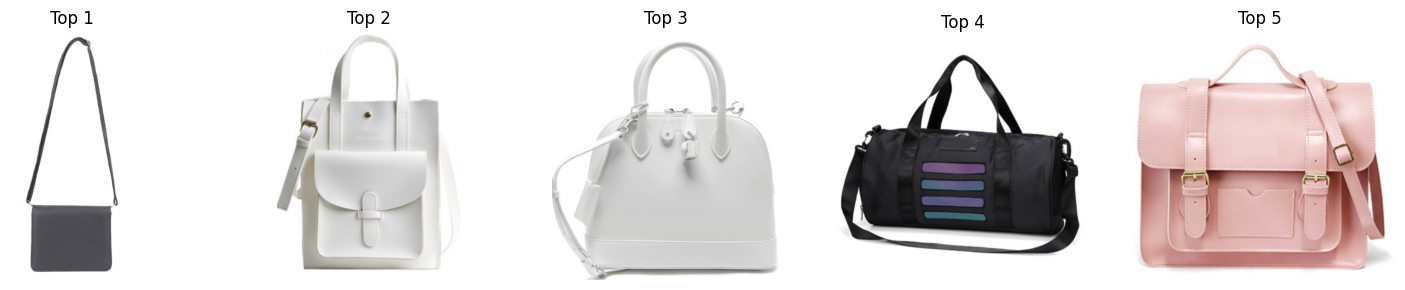

In [23]:
import numpy as np
from tools.clustering import show_cluster_images

show_cluster_images(Dataset, labels, cluster_num=predicted_cluster, num_samples=5)

In [24]:
from tools.clustering import get_cluster_categories

cluster_categories = get_cluster_categories(Dataset, kmeans, features, labels)
print(cluster_categories)

{np.int32(0): 'SW', np.int32(1): 'JK', np.int32(2): 'SC', np.int32(3): 'PT', np.int32(4): 'JP', np.int32(5): 'CT', np.int32(6): 'HC', np.int32(7): 'SH', np.int32(8): 'SE', np.int32(9): 'PT', np.int32(10): 'CD', np.int32(11): 'BG', np.int32(12): 'BL'}


## Similarity check

In [25]:
from tools.similarity2 import Similarity
sim = Similarity(
    feature_vectors=features,
    dataset=Dataset,
    user_name=user_name,
    user_vector=image_features,
    model_type=model,
    force_new=False
)

Saved index and vectors for user default
Saved new features for default



추천 결과:
71개의 유사도가 높은 아이템이 있습니다.

상위 5개 아이템 유사도:
1번째 아이템: 89.81999969482422%
2번째 아이템: 89.66999816894531%
3번째 아이템: 89.66999816894531%
4번째 아이템: 89.38999938964844%
5번째 아이템: 89.20999908447266%


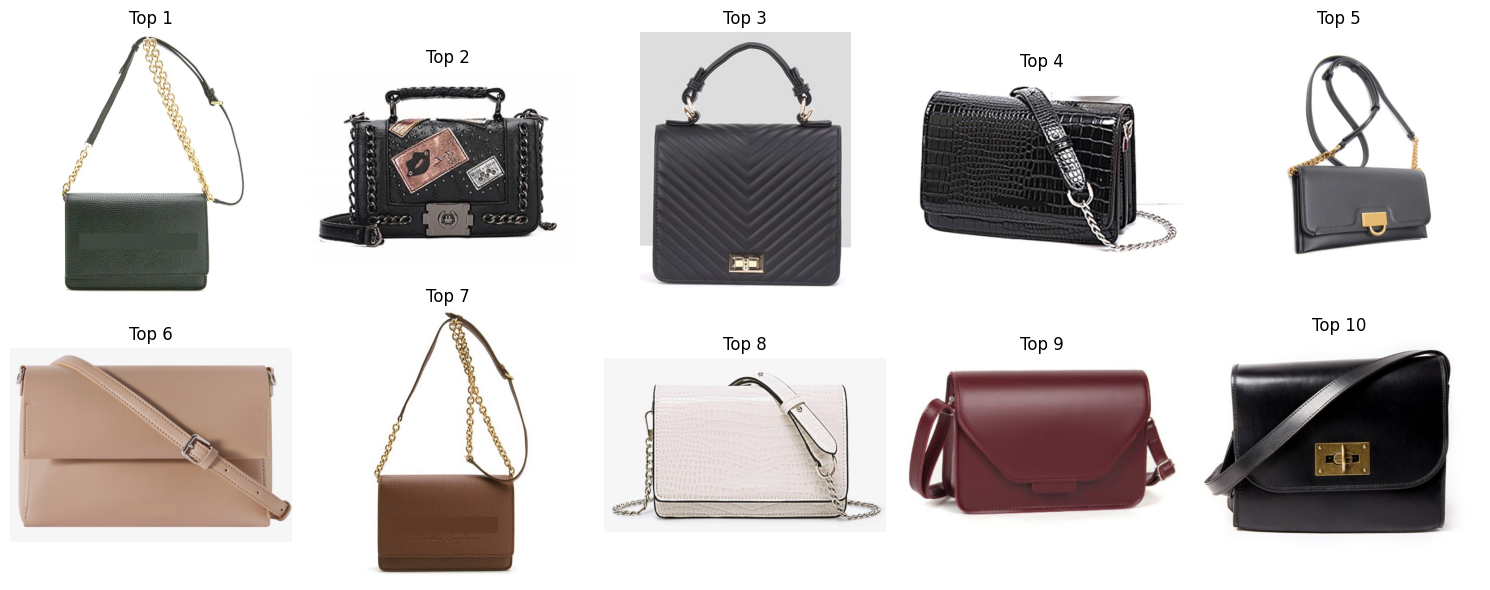

In [26]:
#from tools.similarity import Similarity

#sim = Similarity(features, Dataset)
a=sim.get_sim(image_features, k=10)
percentages, recommendation = sim.attractiveness(image_features, return_percentage=True)

print("\n추천 결과:")
print(recommendation)

print("\n상위 5개 아이템 유사도:")
for i, percent in enumerate(percentages[0][:5], 1):
    print(f"{i}번째 아이템: {percent}%")
Dataset.show_images(a)

## Check clustering

In [27]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

def visualize_in_3d_with_scree_plot(features, labels):
    pca_full = PCA().fit(features)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    
    plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at PC {n_components_90}')
    plt.axvline(x=n_components_80, color='green', linestyle='--', label=f'80% Variance at PC {n_components_80}')
    plt.axvline(x=n_components_70, color='blue', linestyle='--', label=f'70% Variance at PC {n_components_70}')
    plt.legend()
    plt.show()
    
    pca = PCA(n_components=3)
    features_3d = pca.fit_transform(features)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                         c=labels, cmap='tab20c', s=15)
    
    ax.set_title('Clustered Feature 3D Visualization')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    
    plt.show()

def find_optimal_clusters(features, max_clusters=30, plot=True):
    inertias = []
    K = range(10, max_clusters + 1)
    
    for k in K:
        print(f"Testing k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertias.append(kmeans.inertia_)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(K, inertias, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.show()
    
    kn = KneeLocator(
        K, 
        inertias,
        curve='convex',
        direction='decreasing'
    )
    optimal_k = kn.elbow
    
    print(f"최적의 클러스터 수: {optimal_k}")
    return optimal_k

### Elbow point

Testing k=10
Testing k=11
Testing k=12
Testing k=13
Testing k=14
Testing k=15
Testing k=16
Testing k=17
Testing k=18
Testing k=19
Testing k=20
Testing k=21
Testing k=22
Testing k=23
Testing k=24
Testing k=25
Testing k=26
Testing k=27
Testing k=28
Testing k=29
Testing k=30


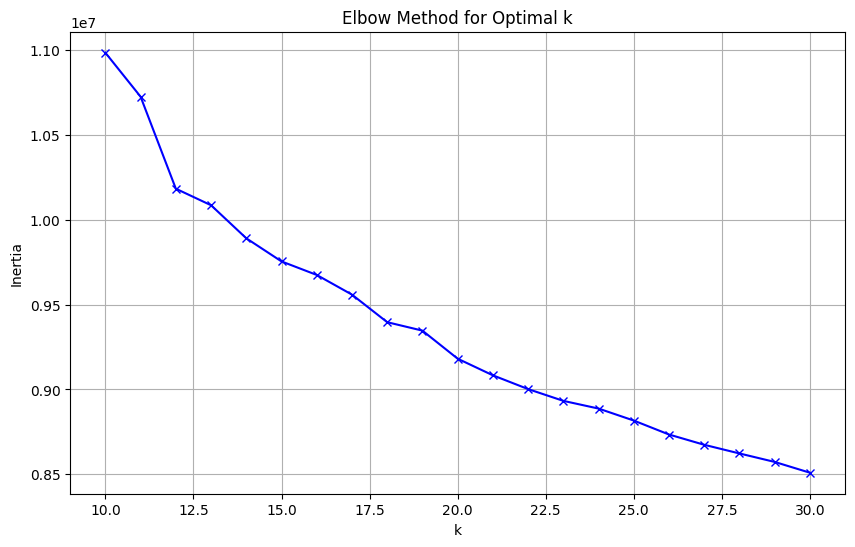

최적의 클러스터 수: 20


In [28]:
optimal_k = find_optimal_clusters(features)

### Scree plot with PCA analysis

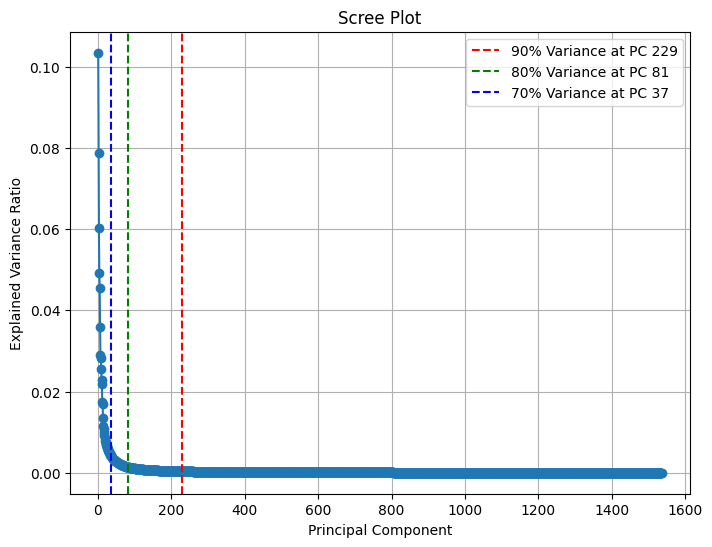

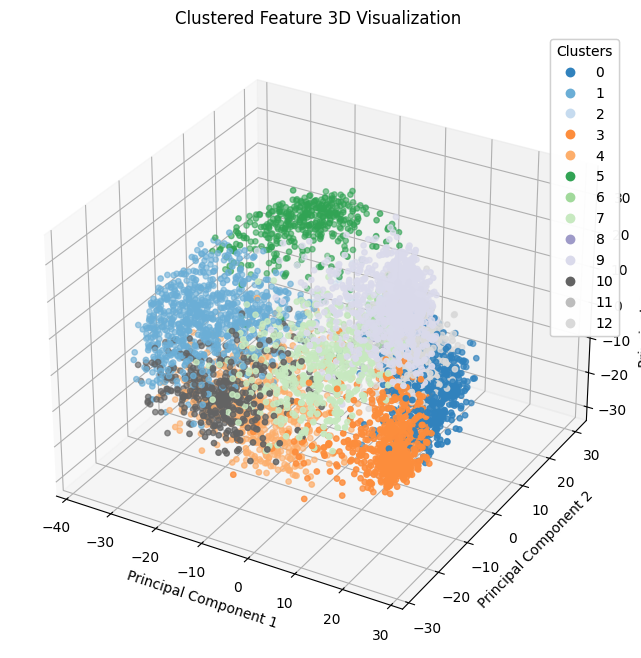

In [29]:
visualize_in_3d_with_scree_plot(features,labels)